In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm
from sklearn.metrics import r2_score

The following notebook will explore correlations between the weather, air quality, drilling and production data. The analysis will include exploration of daily measurements as well as monthly measurements. Following this, a simple model will be fit to try to predict certain air pollutants that show correlation with the weather and UOG data.

First the four sets of data must be combined into one data frame.

In [162]:
# Read in cleaned weather, air quality, drilling, and production files
AQ_data = pd.read_csv('FarmingtonCommunityHall_AQ.csv')
weather_data = pd.read_csv('weather_data.csv')
drill_data = pd.read_csv('drill_final.csv')
production_data_monthly = pd.read_csv('production_monthly.csv')
production_data_daily = pd.read_csv('production_daily.csv')


# Combine cleaned weather and air quality files into one dataframe
AQ_weather_hourly = weather_data.merge(right=AQ_data,
                                     how='inner')
# Reset DateTimeIndex
AQ_weather_hourly = AQ_weather_hourly.set_index(pd.DatetimeIndex(AQ_weather_hourly['Datetime']))

# Resample AQ and weather to daily
# Resample by taking the mean value per day
AQ_weather_daily = AQ_weather_hourly.resample('D').mean()

# Combine daily weather, AQ and drilling and production

# Rename date columns to match AQ and weather and set as Datetime Index
drill_data.rename(columns={'Date':'Datetime'}, inplace=True)
drill_data = drill_data.set_index(pd.DatetimeIndex(drill_data['Datetime']))
drill_data.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_daily = AQ_weather_daily.merge(right=drill_data,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)

# Rename date columns to match AQ and weather and set as Datetime Index
production_data_daily.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_daily = production_data_daily.set_index(pd.DatetimeIndex(production_data_daily['Datetime']))
production_data_daily.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_prod_daily = AQ_weather_drilling_daily.merge(right=production_data_daily,
                                                                 how='inner',
                                                                 left_index=True,
                                                                 right_index=True)

# View df
AQ_weather_drilling_prod_daily.head()


,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3,Depth_per_day,gas_prod_vol_m3
Datetime,,,,,,,,,,,,
2019-01-01,2.879167,261.875000,7.595833,68.220833,0.820833,0.333333,0.268750,0.543750,0.183333,37.122917,252.000000,168187.648387
2019-01-02,4.066667,256.179167,8.525000,64.683333,0.739583,0.283333,0.229167,0.510417,0.104167,37.287500,252.000000,168187.648387
2019-01-03,-6.262500,281.950000,2.079167,72.279167,6.056250,0.297917,0.677083,5.362500,0.110417,28.483333,588.502415,168187.648387
2019-01-04,-7.912500,187.333333,0.779167,88.525000,6.258333,0.687500,0.377083,5.879167,0.172917,24.160417,807.002415,168187.648387
2019-01-05,-9.120833,121.070833,1.870833,88.825000,5.381250,1.010417,0.737500,4.652083,0.139583,26.127083,807.002415,168187.648387


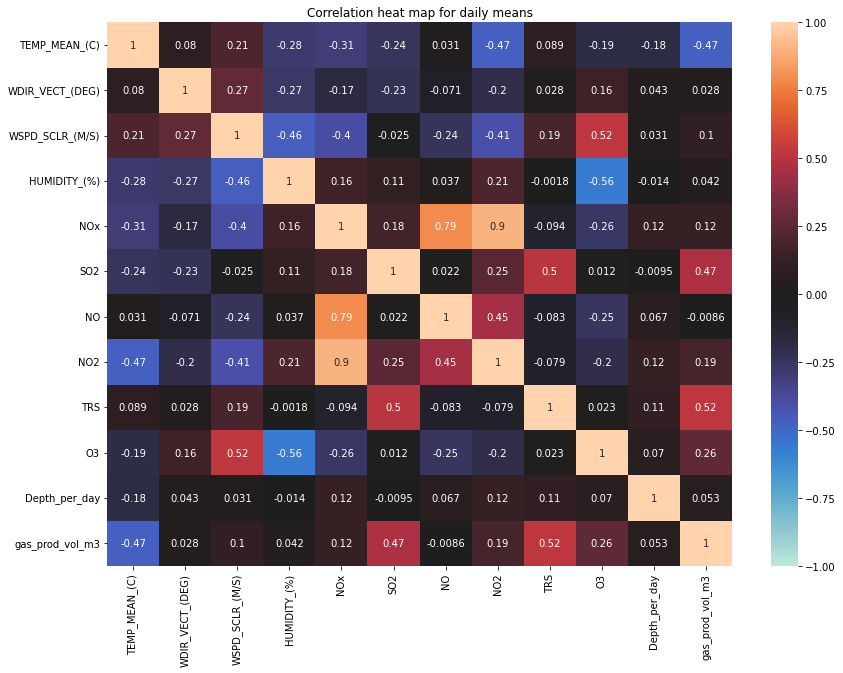

In [163]:
# Plot correlation heat map for all parameters using mean values for weather and AQ and summed values for drilling and production

plt.figure(figsize=(14,10))
sns.heatmap(AQ_weather_drilling_prod_daily.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation heat map for daily means')
plt.show()

From the above figure we see that:
NOx:
 - negatively correlated with temperature and wind speed. NOx is also correlated with NO and NO2
 - shows no correlations with oil and gas data
SO2:
 - negatively correlated with temperature and wind direction and positively correlated with TRS
 - shows a positive correlation with the gas production volumes
NO:
 - slight negative correlation iwth wind speed and a correlation with other N species
NO2:
 - negatively correlated with temperature and wind speed
TRS:
 - correlated with other sulphur species and with gas production volumes
O3:
 - positive correlation with windpeed, negative correlation with humidity
 - slight correlation with gas production volumes

Next the four datasets are combined into a month data frame

In [165]:
# Have to resample seperately - drilling and production needs sum and AQ and weather need mean

# Drilling
drill_data_monthly = drill_data.resample('m').sum()

# Production
production_data_monthly.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_monthly = production_data_monthly.set_index(pd.DatetimeIndex(production_data_monthly['Datetime']))
production_data_monthly.drop('Datetime', axis=1, inplace=True)

# Add common column with just year and month to merge on
drill_data_monthly['month'] = drill_data_monthly.index.get_level_values('Datetime').to_period('M')
production_data_monthly['month'] = production_data_monthly.index.get_level_values('Datetime').to_period('M')

# Merge datasets keeping the index of drilling
drilling_prod_monthly = drill_data_monthly.merge(right=production_data_monthly,
                                                  how='inner',
                                                  on='month')
drilling_prod_monthly.set_index(drill_data_monthly.index, inplace=True)
drilling_prod_monthly.drop('month', axis=1, inplace=True)

# Resample weather and AQ monthly
AQ_weather_monthly = AQ_weather_hourly.resample('m').mean()

# Merge with AQ and weather file
AQ_weather_drilling_prod_monthly = AQ_weather_monthly.merge(right=drilling_prod_monthly,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)
AQ_weather_drilling_prod_monthly.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3,Depth_per_day,gas_prod_vol_m3
Datetime,,,,,,,,,,,,
2019-01-31,-8.364919,225.636962,3.024328,75.877151,5.786626,0.438038,1.044422,4.743817,0.147849,27.624462,98952.575762,5213817.1
2019-02-28,-19.748512,227.183185,1.693452,69.316815,7.262426,0.561086,1.240030,6.024702,0.212054,29.353199,180173.980937,4704358.5
2019-03-31,-3.087097,248.195565,2.157930,62.530780,5.068884,0.409946,0.781788,4.288777,0.174530,34.263306,216898.369108,5223571.0
2019-04-30,3.420625,224.523403,3.285486,57.080972,2.056181,0.290000,0.337431,1.718194,0.142292,34.923264,219187.235484,4807638.7
2019-05-31,10.465188,191.305376,1.963172,57.111156,3.302083,0.211358,0.691868,2.613777,0.160820,30.106384,187231.816727,4561579.5


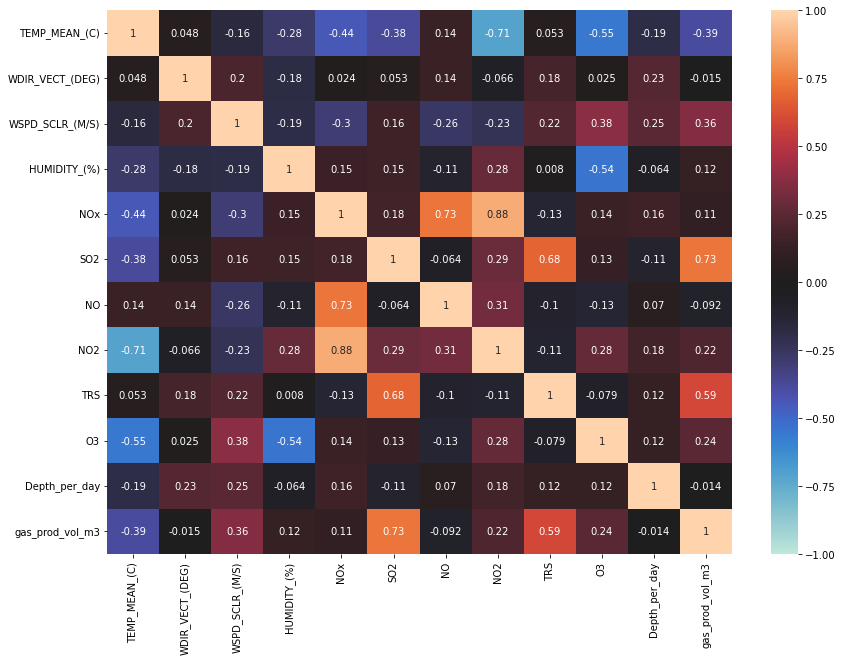

In [56]:
# Plot correlation heat map for all parameters using mean weather and AQ and total drilling and gas production

plt.figure(figsize=(14,10))
sns.heatmap(AQ_weather_drilling_prod_monthly.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.show()

From the figure above we see stronger correlations between SO2 and TRS with the gas production volumes. There is also a small correlation with NO2 and O3 will gas production volumes as well.
There still appears to be no correlation between drilling depths and any AQ species.

Next, the daily dataframe was resampled to weekly and monthly taking the mean value of ALL parameters. For example, rather than comparing the monthly mean AQ and weather data to the total depth drilled and total gas produced in a month, the following figures will explore correlations between the mean AQ and weather data and the mean depth drilled and gas produced.

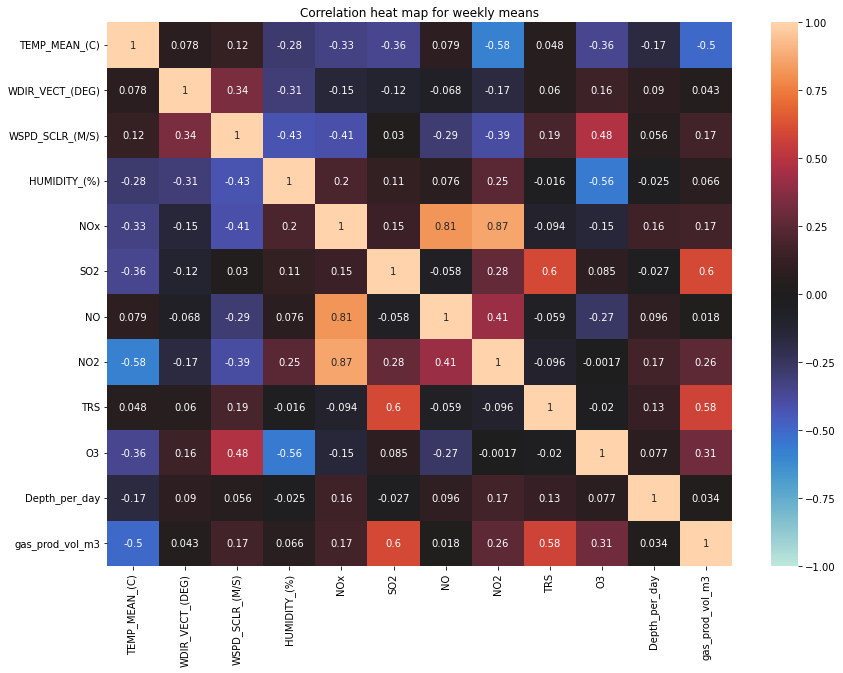

In [167]:
# Re-sample weekly mean for all paramters and plot correlation
week_mean = AQ_weather_drilling_prod_daily.resample('w').mean()

plt.figure(figsize=(14,10))
sns.heatmap(week_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation heat map for weekly means')
plt.show()

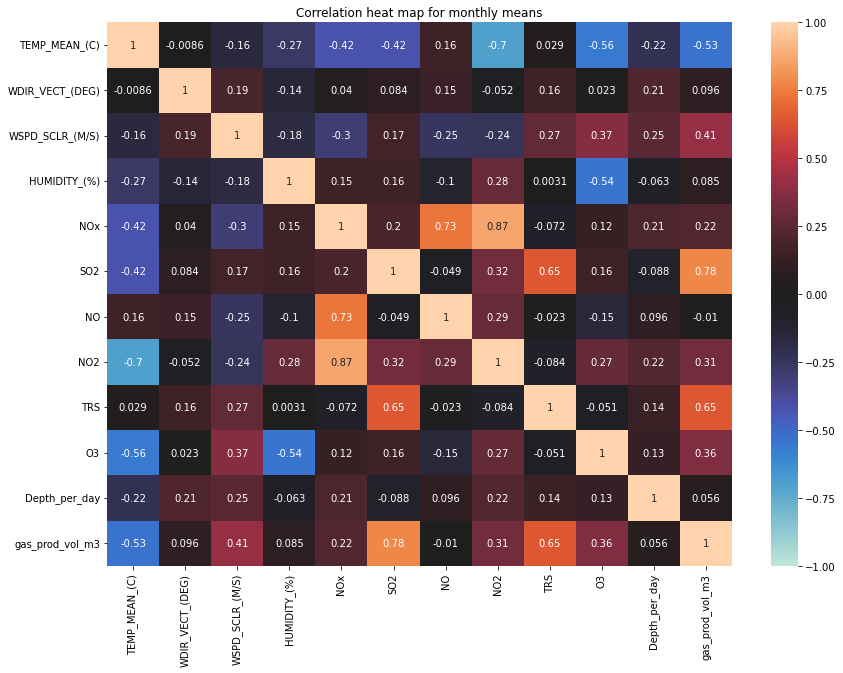

In [168]:
# Re-sample monthly mean for all paramters and plot correlation
month_mean = AQ_weather_drilling_prod_daily.resample('m').mean()

plt.figure(figsize=(14,10))
sns.heatmap(month_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation heat map for monthly means')
plt.show()

From the above figure we see very strong correlations between SO2 and TRS will the mean gas produced in a month. We also see correlations for NO2 and O3 with mean gas produced.

MODEL DEVELOPMENT:

The following section will build models to predict the concentrations of SO2, TRS, NO2 and O3.
The model will use the monthly mean of all parameters, and select dependant variables based on the above correlation heat map.

Y1: SO2     X1: Temperature, X2: Wind speed, X3: Humidity, X4: Gas produced
Y2: TRS     X1: Wind speed, X2: Wind direction, X3: Depth drilled, X4: Gas produced
Y3: NO2     X1: Temperature, X3: Wind speed, X4: Humidity, X5: Depth drilled, X6: Gas produced
Y4: O3      X1: Temperature, X3: Wind speed, X4: Humidity, Gas produced

MODEL 1: SO2

In [296]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['SO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))


Train 66.66666666666666%
Test 33.33333333333333%


In [297]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Fit model to training data
linear_model.fit(X_train, y_train)

# Predict training data y using model
y_fitted = linear_model.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.7226786786987176


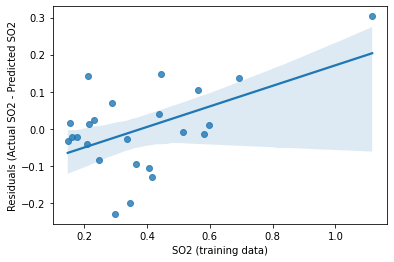

In [298]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')

plt.show()

From the residual plot above we can see the model predicts the lower-medium SO2 concentrations well but over predicts the higher SO2 concentrations. This may be due to high SO2 outliers.

In [299]:
# Now predict the test values and calculate the r-squared score
y_fitted = linear_model.predict(X_test)
print(r2_score(y_test, y_fitted))

0.44212644058445727


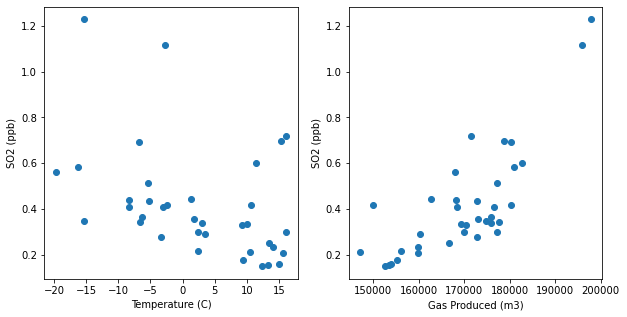

In [204]:
# Lets look at the trends in scatter plot form
y = month_mean['SO2']
x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['gas_prod_vol_m3']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(x1,y)
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('SO2 (ppb)')
ax2.scatter(x2,y)
ax2.set_xlabel('Gas Produced (m3)')
ax2.set_ylabel('SO2 (ppb)')


plt.show()

MODEL 2: TRS

In [288]:
# Split df into x and y
X =  month_mean.filter(['WSPD_SCLR_(M/S)', 'WDIR_VECT_(DEG)', 'Depth_per_day', 'gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['TRS'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [289]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Fit model to training data
linear_model.fit(X_train, y_train)

# Predict training data y using model
y_fitted = linear_model.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.6450973178658226


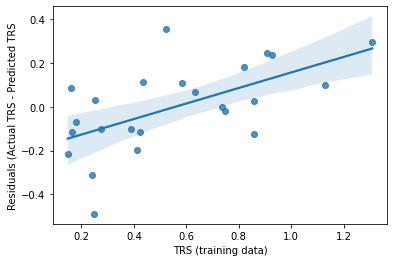

In [290]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('TRS (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')

plt.show()

In [291]:
# Now predict the test values and calculate the r-squared score
y_fitted = linear_model.predict(X_test)
print(r2_score(y_test, y_fitted))

0.2831536336808438


MODEL 3: NO2

In [284]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'Depth_per_day','gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['NO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [285]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Fit model to training data
linear_model.fit(X_train, y_train)

# Predict training data y using model
y_fitted = linear_model.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.4966797481216454


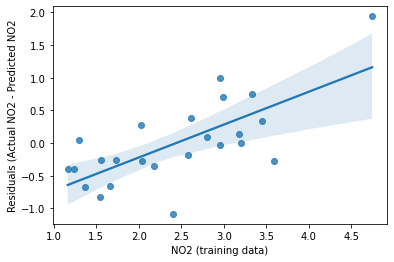

In [286]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['NO2'])
ax.set_xlabel('NO2 (training data)')
ax.set_ylabel('Residuals (Actual NO2 - Predicted NO2')

plt.show()

In [287]:
# Now predict the test values and calculate the r-squared score
y_fitted = linear_model.predict(X_test)
print(r2_score(y_test, y_fitted))

0.6601233580183866


MODEL 4: O3

In [263]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)','gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['O3'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [264]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Fit model to training data
linear_model.fit(X_train, y_train)

# Predict training data y using model
y_fitted = linear_model.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.8234139149816311


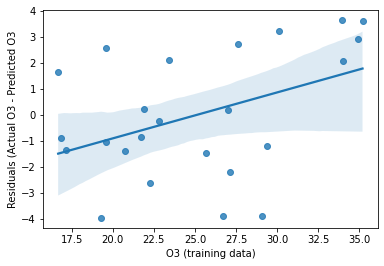

In [265]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['O3'])
ax.set_xlabel('O3 (training data)')
ax.set_ylabel('Residuals (Actual O3 - Predicted O3')

plt.show()

In [266]:
# Now predict the test values and calculate the r-squared score
y_fitted = linear_model.predict(X_test)
print(r2_score(y_test, y_fitted))

0.8687181110844768


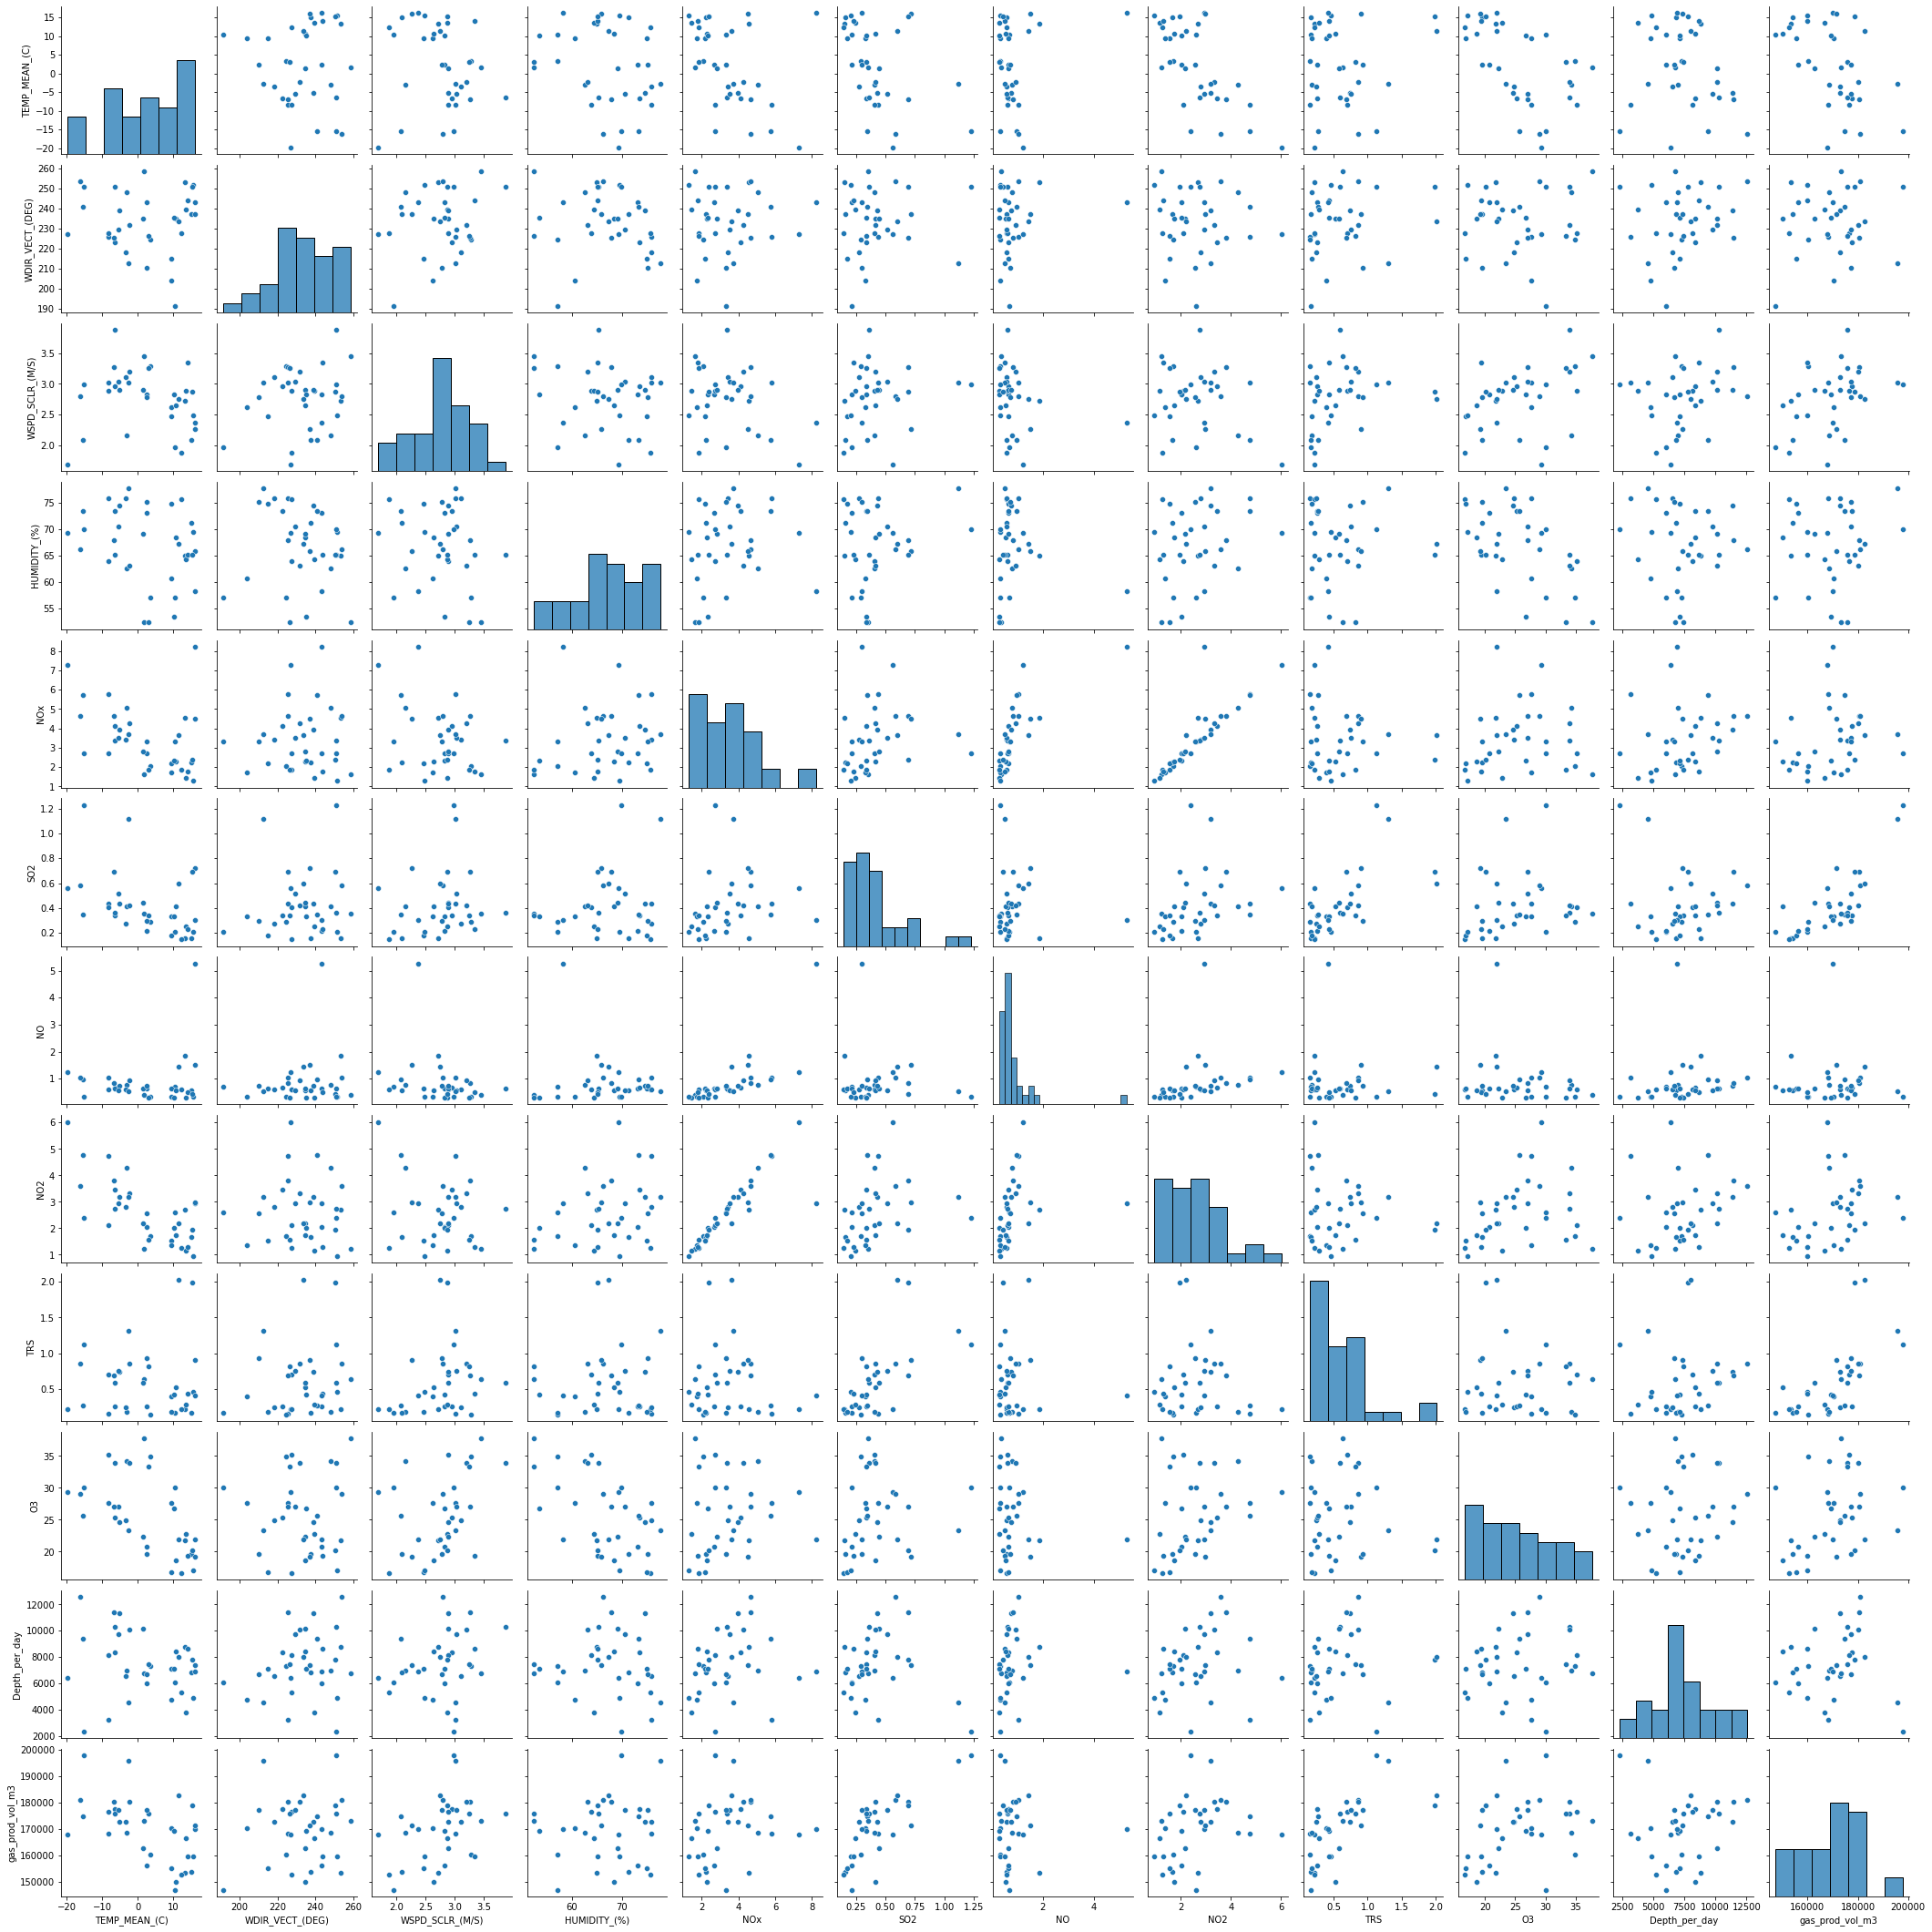

In [267]:
sns.pairplot(month_mean)